# <font color = 'Red'>Problem Statement :


# <font color = 'Blue'># POS tagging using modified Viterbi



In this project we apply techniques to improve Vanilla Viterbi Algorithm. Following are the steps followed:

1. plain vanilla Viterbi Algorithm is developed.


2. Lexicon Technique - approach:
    * Unigram, Bigram and Trigram are considered in case of unknown words.

3. Rule Base Technique - approach:
    * Rule Base is considered in case of unknown words.
    
4. Combine Technique - approach:
    * Combine (use for Unigram, Bigram, Trigram, Rule Base) is considered in case of unknown words.
    
5. Viterbi Modification-Technique I - approach:
    * Transition probability is considered in case of unknown words.

6. Viterbi Modification-Technique II - approach:
     * backoff to a rule based tagger in case of an unknown word.
     * The above technique is modified by using transition probability in approach 2 above if rule based tagger returns default noun tag ('NN').

7. The modified Viterbi algorithms are first tested on sampled test data for comparison.


8. The final algorithm and vanilla Viterbi Algorithm are the tested on full testing data for comparison.

# <font color = 'Green'> Step 1 : Import the Library

In [4]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

from colorama import Fore


pd.options.display.float_format = '{:.4f}'.format

## <font color = 'Green'>Step 2 : Data Preparation

In [5]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [6]:
# let's check some of the tagged data
print(nltk_data[1:5])

[[('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('conglomerate', 'NOUN'), ('.', '.')], [('A', 'DET'), ('form', 'NOUN'), ('of', 'ADP'), ('asbestos', 'NOUN'), ('once', 'ADV'), ('used', 'VERB'), ('*', 'X'), ('*', 'X'), ('to', 'PRT'), ('make', 'VERB'), ('Kent', 'NOUN'), ('cigarette', 'NOUN'), ('filters', 'NOUN'), ('has', 'VERB'), ('caused', 'VERB'), ('a', 'DET

# <font color = 'Green'> Step 3: Split data into train, validation set in the ratio train=95 : test=5

In [7]:
train_set,test_set = train_test_split(nltk_data, test_size = 0.05, random_state = 101)

In [8]:
len(train_set) , len(test_set) 

(3718, 196)

### <font color = 'Blue'> Understanding the dataset

In [9]:
train_set[0]

[('Reliance', 'NOUN'),
 ('confirmed', 'VERB'),
 ('the', 'DET'),
 ('filing', 'NOUN'),
 ('but', 'CONJ'),
 ('would', 'VERB'),
 ("n't", 'ADV'),
 ('elaborate', 'VERB'),
 ('.', '.')]

In [10]:
# create list of train and test tagged words


train_tagged_words = [word for sentence in train_set for word in sentence ]
test_tagged_words = [word[0] for sentence in test_set for word in sentence ]

In [11]:
len(train_tagged_words) , len(test_tagged_words) 

(95547, 5129)

In [12]:
# check some of the tagged words.
train_tagged_words[1:5]

[('confirmed', 'VERB'), ('the', 'DET'), ('filing', 'NOUN'), ('but', 'CONJ')]

In [13]:
# check some of the tagged words.
test_tagged_words[:9]

['The', 'company', 'said', '0', 'it', 'is', 'in', 'the', 'process']

In [14]:
# Checking unique tags are present in training data

tags = {tag for word, tag in train_tagged_words}

In [15]:
print(len(tags))
print("Tags : ", tags)

12
Tags :  {'VERB', 'NOUN', 'X', 'ADP', 'ADV', 'CONJ', 'PRT', '.', 'PRON', 'ADJ', 'DET', 'NUM'}


In [16]:
# Checking unique vocalbulary are present in training data

vocal = {word for word, tag in train_tagged_words}

In [17]:
print(f"{Fore.GREEN}\n")
print(len(vocal))
# print("vocal : ", vocal)



12100


# <font color = 'Green'> Step 4: POS Tagging algorithm using Hidden Markov Model (HMM)
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. In other words, to every word w, assign the tag t that maximises the likelihood P(t/w).

Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

Now:

P(w/t): is the emission probability of a given word for a given tag. This can be computed based on the fraction of given word for given tag to the total count of that tag, ie: P(w/t) = count(w, t) / count(t).

P(t): is the probability of tag (also transition probability), and in a tagging task, we assume that a tag will depend only on the previous tag (Markov order 1 assumption). In other words, the probability of say a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

### <font color = 'Blue'>Build the vanilla Viterbi based POS tagger

### <font color = 'Red'>  Function to compute emission probabilties for a given word

In [18]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    taglist = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(taglist)    
    
    w_in_tag = [pair[0] for pair in taglist if pair[0]==word]    
    word_count_given_tag = len(w_in_tag)    
    
    return (word_count_given_tag,tag_count)

### <font color = 'Red'> Function to compute transition probabilties for a given tag and previous tag

In [19]:
def t2_given_t1(t2,t1,train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    
    t1_tags = [tag for tag in tags if tag==t1]
    
    count_of_t1 = len(t1_tags)
    
    t2_given_t1 = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    
    count_t2_given_t1 = len(t2_given_t1)
    
    return(count_t2_given_t1,count_of_t1)

In [20]:
t2_given_t1('NOUN','DET')

(5284, 8281)

### <font color = 'Red'> Creating function t x t transition matrix  of tags

In [21]:
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
def tag_matrix(tags_val = tags):
    tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
    
    for i, t1 in enumerate(list(tags)):
        
        for j, t2 in enumerate(list(tags)): 
            
            tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
            
    return tags_matrix

In [22]:
tags_matrix = tag_matrix(tags)

In [23]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,VERB,NOUN,X,ADP,ADV,CONJ,PRT,.,PRON,ADJ,DET,NUM
VERB,0.1692,0.1101,0.2175,0.0920,0.0820,0.0056,0.0307,0.0349,0.0358,0.0650,0.1344,0.0229
NOUN,0.1477,0.2636,0.0292,0.1765,0.0171,0.0427,0.0434,0.2406,0.0046,0.0122,0.0129,0.0095
X,0.2039,0.0624,0.0764,0.1426,0.0250,0.0107,0.1852,0.1636,0.0555,0.0172,0.0547,0.0029
ADP,0.0083,0.3210,0.0344,0.0169,0.0140,0.0010,0.0014,0.0390,0.0700,0.1070,0.3247,0.0622
ADV,0.3435,0.0315,0.0232,0.1186,0.0805,0.0070,0.0142,0.1371,0.0149,0.1292,0.0699,0.0305
CONJ,0.1567,0.3491,0.0088,0.0525,0.0553,0.0005,0.0046,0.0349,0.0581,0.1181,0.1213,0.0400
PRT,0.4053,0.2478,0.0135,0.0201,0.0102,0.0023,0.0016,0.0438,0.0178,0.0830,0.0979,0.0567
.,0.0891,0.2222,0.0270,0.0913,0.0523,0.0575,0.0024,0.0933,0.0663,0.0440,0.1733,0.0810
PRON,0.4855,0.2109,0.0900,0.0230,0.0341,0.0054,0.0130,0.0410,0.0077,0.0731,0.0100,0.0065
ADJ,0.0117,0.6996,0.0211,0.0783,0.0048,0.0170,0.0107,0.0639,0.0003,0.0664,0.0049,0.0213


In [24]:
tags_df.loc['.', :]

VERB   0.0891
NOUN   0.2222
X      0.0270
ADP    0.0913
ADV    0.0523
CONJ   0.0575
PRT    0.0024
.      0.0933
PRON   0.0663
ADJ    0.0440
DET    0.1733
NUM    0.0810
Name: ., dtype: float32

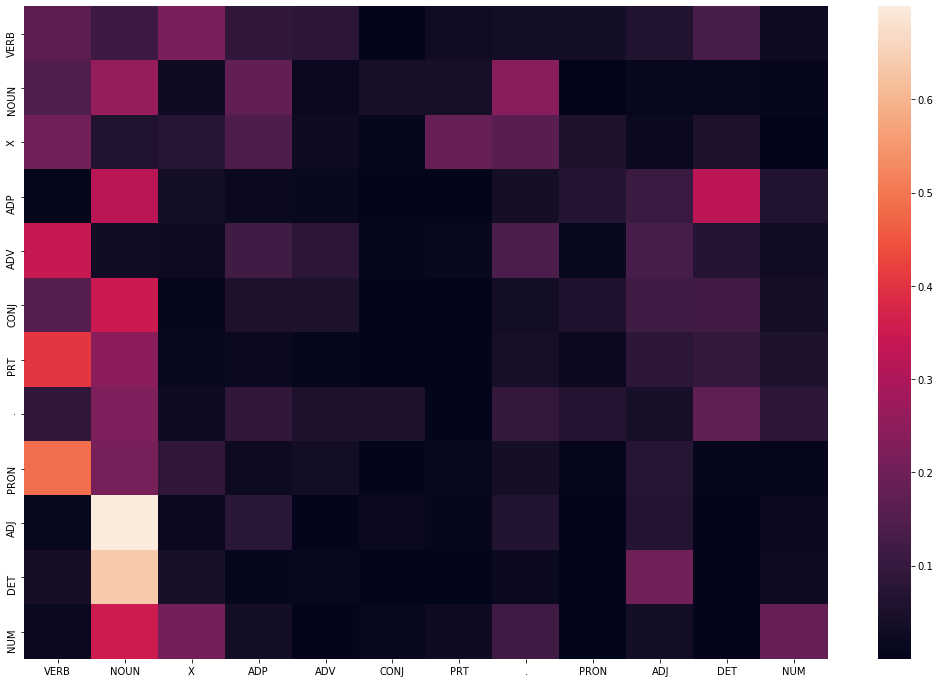

In [25]:
# heatmap of tags matrix
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

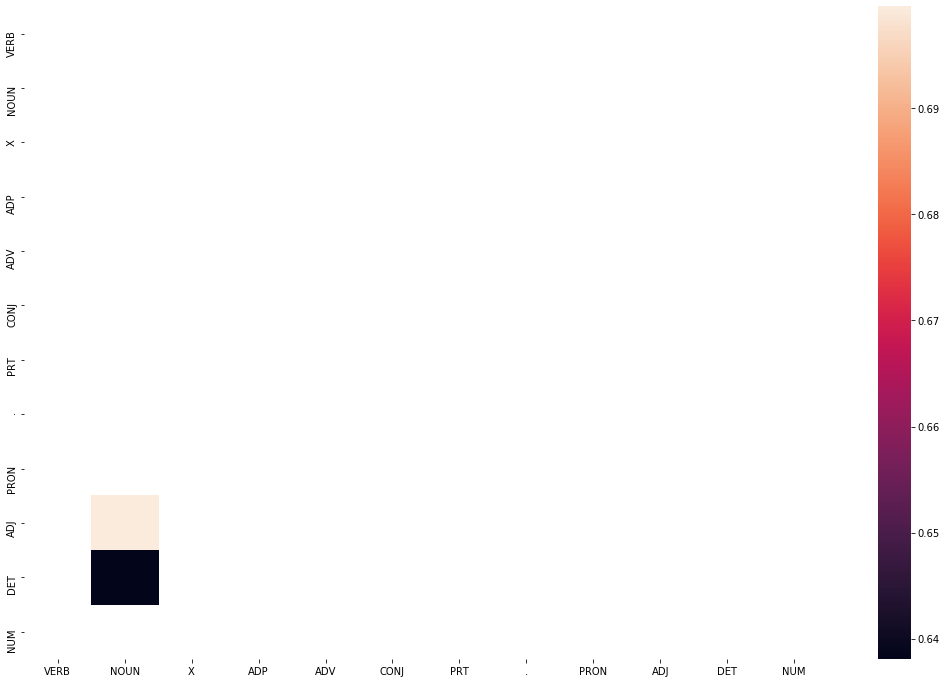

In [26]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5


tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

# <font color = 'Green'> Step 5:  Viterbi Algorithm

### <font color = 'Blue'> The steps are as follows:

1. Given a sequence of words
2. iterate through the sequence
3. for each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
4. assign the tag which has maximum probability obtained in step 3 above.
5. move to the next word in sequence to repeat steps 3 and 4 above.

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

### <font color = 'Red'> Function for Vanilla Viterbi Algorithm


In [27]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

# <font color = 'Green'> Step 6: Evaluating on Test Set
    
 Testing Vanilla Viterbi Algorithm on sampled test data


In [28]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]
print("random value : \n" , rndom)
print("*"*100, " \n\n")

# list of sents
test_run = [test_set[i] for i in rndom]
print("test_run 0th position value : \n" , test_run[0])
print("*"*100, " \n\n")

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
print("test_run_base 0th to 5th position value : \n" , test_run_base[0 : 5])
print("*"*100, " \n\n")

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
print("test_tagged_words 0th to 5th position value : \n" , test_tagged_words[0 : 5])
print("*"*100, " \n\n")


random value : 
 [113, 30, 2, 24, 150]
****************************************************************************************************  


test_run 0th position value : 
 [('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'NOUN'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'NOUN'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.')]
****************************************************************************************************  


test_run_base 0th to 5th position value : 
 [('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'NOUN'), (',', '.')]
****************************************************************************************************  


test_tagged_words 0th to 5th p

In [29]:
def check_accuracy(viterbi_function , test_tagged_words_val, test_run_base_val, model_name = "Model "):
    # tagging the test sentences
    start = time.time()
    tagged_seq = viterbi_function(test_tagged_words_val)
    end = time.time()
    difference = end-start
    
    print("Time taken in seconds: ", difference)
    print("*"*100, " \n\n")
    
    
    # accuracy
    check = [i for i, j in zip(tagged_seq, test_run_base_val) if i == j] 
    accuracy = len(check)/len(tagged_seq) * 100
    
    print(model_name, ' Algorithm Accuracy: ',accuracy)
    print("*"*100, " \n\n")
    
    #check the incorrectly tagged words and accuracy
    check_incorrect = [j for i, j in enumerate(zip(tagged_seq, test_run_base_val)) if j[0] != j[1]]
    accuracy_incorrected = len(check_incorrect)/len(tagged_seq) * 100
    
    print(model_name,' Algorithm Incorrected Accuracy: ',accuracy_incorrected)
    print("*"*100, " \n\n")
    
    print("test_tagged_words : \n",test_tagged_words_val)
    print("*"*100, " \n\n")
    
    print("Incorrect test_tagged_words : \n",check_incorrect)
    
    return [model_name, accuracy, accuracy_incorrected]

In [30]:
model_detail_df = pd.DataFrame( columns = ["Model Name", "Correct Accuracy", "Incorrect Accuracy"])
model_detail_df

,Model Name,Correct Accuracy,Incorrect Accuracy


In [31]:
model_detail = check_accuracy(Viterbi, test_tagged_words, test_run_base,"Vanilla Viterbi")

Time taken in seconds:  18.30980610847473
****************************************************************************************************  


Vanilla Viterbi  Algorithm Accuracy:  91.1504424778761
****************************************************************************************************  


Vanilla Viterbi  Algorithm Incorrected Accuracy:  8.849557522123893
****************************************************************************************************  


test_tagged_words : 
 ['The', 'Contra', 'military', 'command', ',', 'in', 'a', 'statement', 'from', 'Honduras', ',', 'said', '0', 'Sandinista', 'troops', 'had', 'launched', 'a', 'major', 'offensive', 'against', 'the', 'rebel', 'forces', '.', '*-1', 'Bucking', 'the', 'market', 'trend', ',', 'an', 'issue', 'of', '$', '130', 'million', '*U*', 'general', 'obligation', 'distributable', 'state', 'aid', 'bonds', 'from', 'Detroit', ',', 'Mich.', ',', 'apparently', 'drew', 'solid', 'investor', 'interest', '.', 'Ralston', 's

In [32]:
model_detail_df.loc[0] = model_detail
model_detail_df.head()

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496


In [33]:
## Testing
sentence_test1 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words1 = word_tokenize(sentence_test1)

start = time.time()
tagged_seq1 = Viterbi(words1)
end = time.time()
difference = end-start

print("time : ", difference)
print(tagged_seq1)


time :  2.6626369953155518
[('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]


# <font color = 'Green'> Step 7:  Solve the problem of unknown words

## <font color = 'Blue'> Different Types of techniques:

1. Use Lexical techniqies on the same data to see if we get better <br>
2. Use Rule Base  techniqies on the same data to see if we get better <br>
3. Use Combine techniqies on the same data to see if we get better <br>
4. Use these to tag unknown words, then see if we get better.

### <font color = 'orange'> Unigram Tagger:

In [34]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)  * 100
print("accuracy_unigram_tagger : ", accuracy_unigram_tagger)

accuracy_unigram_tagger :  90.6999415090661


## <font color = 'orange'> Bigram Tagger:

In [35]:
# Lexicon (or bigram tagger)
bigram_tagger = nltk.BigramTagger(train_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)  * 100
print("accuracy_bigram_tagger : ", accuracy_bigram_tagger)

accuracy_bigram_tagger :  21.778124390719437


## <font color = 'orange'> Trigram Tagger:

In [36]:
trigram_tagger = nltk.TrigramTagger(train_set)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set) * 100
print("accuracy_trigram_tagger : ", accuracy_trigram_tagger)


accuracy_trigram_tagger :  11.132774419964905


In [37]:
unigram_details = ["Lexicon Unigram", accuracy_unigram_tagger, 100 - accuracy_unigram_tagger]
bigram_details =  ["Lexicon Bigram", accuracy_bigram_tagger, 100 - accuracy_bigram_tagger]
trigram_details = ["Lexicon Trigram", accuracy_trigram_tagger, 100 - accuracy_trigram_tagger]

model_detail_df.loc[1] = unigram_details
model_detail_df.loc[2] = bigram_details
model_detail_df.loc[3] = trigram_details
model_detail_df.head()

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496
1,Lexicon Unigram,90.6999,9.3001
2,Lexicon Bigram,21.7781,78.2219
3,Lexicon Trigram,11.1328,88.8672


# <font color = 'orange'> Rule Based Tagger:

In [38]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

In [39]:
regexp_tagger = nltk.RegexpTagger(patterns)
accuracy_rule_base_tagger = regexp_tagger.evaluate(test_set)  * 100
print("accuracy_rule_base_tagger : ", accuracy_rule_base_tagger)

accuracy_rule_base_tagger :  0.0


## <font color = 'orange'> Combining Taggers :

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

NLTK provides a convenient way to combine taggers using the 'backup' argument. In the following code, we create a regex tagger which is used as a backup tagger to the lexicon tagger, i.e. when the tagger is not able to tag using the lexicon (in case of a new word not in the vocabulary), it uses the rule-based tagger. 

Also, note that the rule-based tagger itself is backed up by the tag 'NN'.


In [40]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

combine_lexicon_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger) # lexicon backed up by the rule-based tagger

accuracy_combine_lexicon_rule_tagger = combine_lexicon_tagger.evaluate(test_set)  * 100

print("accuracy_combine_lexicon_rule_tagger : ",accuracy_combine_lexicon_rule_tagger)

accuracy_combine_lexicon_rule_tagger :  90.6999415090661


In [41]:
# Bigram and Trigram tagger
combine_bigram_tagger = nltk.BigramTagger(train_set,backoff = combine_lexicon_tagger)

accuracy_combine_lexicon_bigram_rule_tagger = combine_bigram_tagger.evaluate(test_set)  * 100

print("accuracy_combine_lexicon_bigram_rule_tagger : ", accuracy_combine_lexicon_bigram_rule_tagger)

accuracy_combine_lexicon_bigram_rule_tagger :  91.0898810684344


In [42]:
combine_trigram_tagger = nltk.TrigramTagger(train_set, backoff = combine_bigram_tagger)

accuracy_combine_lexicon__unigram_bigram_rule_tagger = combine_trigram_tagger.evaluate(test_set)  * 100

print("accuracy_trigram_tagger : ", accuracy_combine_lexicon__unigram_bigram_rule_tagger)

accuracy_trigram_tagger :  91.10937804640281


In [43]:
rule_base_details = ["Rule Base", accuracy_rule_base_tagger, 100 - accuracy_rule_base_tagger]
combine_lexicon_rule_details =  ["Combine Lexicon Unigram Rule Base ", accuracy_combine_lexicon_rule_tagger, 100 - accuracy_combine_lexicon_rule_tagger]
combine_lexicon_bigram_rule_details = ["Combine Lexicon Unigram Bigram Rule Base", accuracy_combine_lexicon_bigram_rule_tagger, 100 - accuracy_combine_lexicon_bigram_rule_tagger]
combine_lexicon_unigram_bigram_rule_details = ["Combine Lexicon Unigram Bigram Trigram Rule Base", accuracy_combine_lexicon__unigram_bigram_rule_tagger, 100 - accuracy_combine_lexicon__unigram_bigram_rule_tagger]

model_detail_df.loc[4] = rule_base_details
model_detail_df.loc[5] = combine_lexicon_rule_details
model_detail_df.loc[6] = combine_lexicon_bigram_rule_details
model_detail_df.loc[7] = combine_lexicon_unigram_bigram_rule_details
model_detail_df.head(10)

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496
1,Lexicon Unigram,90.6999,9.3001
2,Lexicon Bigram,21.7781,78.2219
3,Lexicon Trigram,11.1328,88.8672
4,Rule Base,0.0000,100.0000
5,Combine Lexicon Unigram Rule Base,90.6999,9.3001
6,Combine Lexicon Unigram Bigram Rule Base,91.0899,8.9101
7,Combine Lexicon Unigram Bigram Trigram Rule Base,91.1094,8.8906


Getting marginally better, but not by much. <br>
Next lets see if we can use this for the unknown words 

## <font color = 'Green'> Optimization

We can see that all of unknown words have been tagged as 'NUM' as 'NUM' is the first tag in tag list and is assigned if unknown word is encountered (emission probability =0).

### <font color = 'Blue'> A)Viterbi Modification-Technique I

* **First solution for unknown words**: assign based on transition probabilities only in case of unknown words as emission probability for unknown word is zero.

In [44]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] #todo 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [45]:
model_detail_1 = check_accuracy(Viterbi_1,test_tagged_words,test_run_base,"Vanilla Viterbi 1")


Time taken in seconds:  17.67174744606018
****************************************************************************************************  


Vanilla Viterbi 1  Algorithm Accuracy:  94.69026548672566
****************************************************************************************************  


Vanilla Viterbi 1  Algorithm Incorrected Accuracy:  5.3097345132743365
****************************************************************************************************  


test_tagged_words : 
 ['The', 'Contra', 'military', 'command', ',', 'in', 'a', 'statement', 'from', 'Honduras', ',', 'said', '0', 'Sandinista', 'troops', 'had', 'launched', 'a', 'major', 'offensive', 'against', 'the', 'rebel', 'forces', '.', '*-1', 'Bucking', 'the', 'market', 'trend', ',', 'an', 'issue', 'of', '$', '130', 'million', '*U*', 'general', 'obligation', 'distributable', 'state', 'aid', 'bonds', 'from', 'Detroit', ',', 'Mich.', ',', 'apparently', 'drew', 'solid', 'investor', 'interest', '.', 'Ralsto

In [46]:
model_detail_df.loc[8] = model_detail_1
model_detail_df.head(10)

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496
1,Lexicon Unigram,90.6999,9.3001
2,Lexicon Bigram,21.7781,78.2219
3,Lexicon Trigram,11.1328,88.8672
4,Rule Base,0.0000,100.0000
5,Combine Lexicon Unigram Rule Base,90.6999,9.3001
6,Combine Lexicon Unigram Bigram Rule Base,91.0899,8.9101
7,Combine Lexicon Unigram Bigram Trigram Rule Base,91.1094,8.8906
8,Vanilla Viterbi 1,94.6903,5.3097


### <font color = 'Blue'> Adding Tag occurance probability weights: 

we will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

This scheme will also take into account that some POS tags are more likely to occur as compared to others.

In [47]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('VERB', 0.1351167488251855),
 ('NOUN', 0.2862674913916711),
 ('X', 0.06576867928872701),
 ('ADP', 0.0978889970381069),
 ('ADV', 0.031597015081582885),
 ('CONJ', 0.02251248076862696),
 ('PRT', 0.03176447193527793),
 ('.', 0.11641391147812072),
 ('PRON', 0.0273373313657153),
 ('ADJ', 0.06351847781719991),
 ('DET', 0.08666938784053921),
 ('NUM', 0.035145007169246546)]

In [48]:
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [49]:
model_detail_2 = check_accuracy(Viterbi_2,test_tagged_words,test_run_base,"Vanilla Viterbi 2")

Time taken in seconds:  17.81160020828247
****************************************************************************************************  


Vanilla Viterbi 2  Algorithm Accuracy:  95.57522123893806
****************************************************************************************************  


Vanilla Viterbi 2  Algorithm Incorrected Accuracy:  4.424778761061947
****************************************************************************************************  


test_tagged_words : 
 ['The', 'Contra', 'military', 'command', ',', 'in', 'a', 'statement', 'from', 'Honduras', ',', 'said', '0', 'Sandinista', 'troops', 'had', 'launched', 'a', 'major', 'offensive', 'against', 'the', 'rebel', 'forces', '.', '*-1', 'Bucking', 'the', 'market', 'trend', ',', 'an', 'issue', 'of', '$', '130', 'million', '*U*', 'general', 'obligation', 'distributable', 'state', 'aid', 'bonds', 'from', 'Detroit', ',', 'Mich.', ',', 'apparently', 'drew', 'solid', 'investor', 'interest', '.', 'Ralston

In [50]:
model_detail_df.loc[9] = model_detail_2
model_detail_df.head(10)

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496
1,Lexicon Unigram,90.6999,9.3001
2,Lexicon Bigram,21.7781,78.2219
3,Lexicon Trigram,11.1328,88.8672
4,Rule Base,0.0000,100.0000
5,Combine Lexicon Unigram Rule Base,90.6999,9.3001
6,Combine Lexicon Unigram Bigram Rule Base,91.0899,8.9101
7,Combine Lexicon Unigram Bigram Trigram Rule Base,91.1094,8.8906
8,Vanilla Viterbi 1,94.6903,5.3097
9,Vanilla Viterbi 2,95.5752,4.4248


**Thus, we see that we have got a much better accuracy by using weighted transition probabilties.**

### The following list of words have been correctly POS tagged by Viterbi_1 as compared to vanilla Viterbi Algorithm:

Contra:correctly tagged as NOUN
Honduras:correctly tagged as NOUN
complaining: correctly tagged as VERB
Bucking: correctly tagged as VERB

### <font color = 'Blue'> B) Viterbi Modification-Technique II

    

# **second solution for unknown words:** 

* backoff to rule based tagger in case of unknown words.
* we further observe that POS tag 'X' can be easily encapsulated in regex rule, so we extract it only based on ruled based tagged.

Let's define a rule based tagger as below:

In [51]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [52]:
# Modification in Viterbi Algorithm : Backoff to rule based tagger in case unknown word is encountered.
def Viterbi_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))

In [53]:
model_detail_3 = check_accuracy(Viterbi_3,test_tagged_words,test_run_base,"Vanilla Viterbi 3")

Time taken in seconds:  18.08884835243225
****************************************************************************************************  


Vanilla Viterbi 3  Algorithm Accuracy:  97.34513274336283
****************************************************************************************************  


Vanilla Viterbi 3  Algorithm Incorrected Accuracy:  2.6548672566371683
****************************************************************************************************  


test_tagged_words : 
 ['The', 'Contra', 'military', 'command', ',', 'in', 'a', 'statement', 'from', 'Honduras', ',', 'said', '0', 'Sandinista', 'troops', 'had', 'launched', 'a', 'major', 'offensive', 'against', 'the', 'rebel', 'forces', '.', '*-1', 'Bucking', 'the', 'market', 'trend', ',', 'an', 'issue', 'of', '$', '130', 'million', '*U*', 'general', 'obligation', 'distributable', 'state', 'aid', 'bonds', 'from', 'Detroit', ',', 'Mich.', ',', 'apparently', 'drew', 'solid', 'investor', 'interest', '.', 'Ralsto

In [54]:
model_detail_df.loc[10] = model_detail_3
model_detail_df.head(15)

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496
1,Lexicon Unigram,90.6999,9.3001
2,Lexicon Bigram,21.7781,78.2219
3,Lexicon Trigram,11.1328,88.8672
4,Rule Base,0.0000,100.0000
5,Combine Lexicon Unigram Rule Base,90.6999,9.3001
6,Combine Lexicon Unigram Bigram Rule Base,91.0899,8.9101
7,Combine Lexicon Unigram Bigram Trigram Rule Base,91.1094,8.8906
8,Vanilla Viterbi 1,94.6903,5.3097
9,Vanilla Viterbi 2,95.5752,4.4248


The following list of words have been correctly POS tagged by Viterbi 3 as compared to vanilla Viterbi Algorithm:

* Contra:correctly tagged as NOUN
* Honduras:correctly tagged as NOUN
* complaining: correctly tagged as VERB
* Bucking: correctly tagged as VERB

the following list of words has been correctly tagged by Viterbi 3 as compared to Viterbi_1

* Sandinista: correctly tagged as NOUN
* Eveready: correctly tagged as NOUN
* `*T*-252`: correctly tagged as 'X'

### <font color = 'Blue'> further modification in Viterb 4:
 
 
We know that the rule based tagger assigns 'NOUN' by default if word does not fall in any rule, to correct this let's assign the tags for any such word based purely on transition probability of tags.

So, first we will modify the rule based tagger to output 'NN' instead of 'NOUN' in case word does not satisfy any rules. We also observe that any capitalized word can still be defaulted as 'NOUN' so will add one more rule for that case.

In [55]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [56]:
# modified Viterbi
def Viterbi_4(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [57]:
model_detail_4 = check_accuracy(Viterbi_4,test_tagged_words,test_run_base,"Vanilla Viterbi 4")

Time taken in seconds:  18.112403631210327
****************************************************************************************************  


Vanilla Viterbi 4  Algorithm Accuracy:  98.23008849557522
****************************************************************************************************  


Vanilla Viterbi 4  Algorithm Incorrected Accuracy:  1.7699115044247788
****************************************************************************************************  


test_tagged_words : 
 ['The', 'Contra', 'military', 'command', ',', 'in', 'a', 'statement', 'from', 'Honduras', ',', 'said', '0', 'Sandinista', 'troops', 'had', 'launched', 'a', 'major', 'offensive', 'against', 'the', 'rebel', 'forces', '.', '*-1', 'Bucking', 'the', 'market', 'trend', ',', 'an', 'issue', 'of', '$', '130', 'million', '*U*', 'general', 'obligation', 'distributable', 'state', 'aid', 'bonds', 'from', 'Detroit', ',', 'Mich.', ',', 'apparently', 'drew', 'solid', 'investor', 'interest', '.', 'Ralst

In [58]:
model_detail_df.loc[11] = model_detail_4
model_detail_df.head(15)

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496
1,Lexicon Unigram,90.6999,9.3001
2,Lexicon Bigram,21.7781,78.2219
3,Lexicon Trigram,11.1328,88.8672
4,Rule Base,0.0000,100.0000
5,Combine Lexicon Unigram Rule Base,90.6999,9.3001
6,Combine Lexicon Unigram Bigram Rule Base,91.0899,8.9101
7,Combine Lexicon Unigram Bigram Trigram Rule Base,91.1094,8.8906
8,Vanilla Viterbi 1,94.6903,5.3097
9,Vanilla Viterbi 2,95.5752,4.4248


#<font color = 'brown'>We observe that much better accuracy is obtained now.

The following list of words have been correctly POS tagged by Viterbi_4 as compared to vanilla Viterbi Algorithm:
* Contra:correctly tagged as NOUN
* Honduras:correctly tagged as NOUN
* complaining: correctly tagged as VERB
* Bucking: correctly tagged as VERB

the following list of words has been correctly tagged by Viterbi_4 as compared to Viterbi_1
* Sandinista: correctly tagged as NOUN
* Eveready: correctly tagged as NOUN
* `*T*-252`: correctly tagged as 'X'
* drew: correctly tagged as VERB

# <font color = 'Green'>Step 8: Evaluating tagging accuracy

In [59]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base = [tup for sent in test_set for tup in sent]

In [60]:
test_tagged_words[:10]

['The', 'company', 'said', '0', 'it', 'is', 'in', 'the', 'process', 'of']

In [80]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Time taken in seconds:  891.9741384983063
Viterbi Algorithm Accuracy:  92.12322090076039


In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_4(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy: ',accuracy*100)

# <font color = 'Green'> Evaluating tagging on sample 'Test_sentences.txt' file



In [62]:
f = open('Test_sentences.txt')
text = f.read()
sample_test_sent = text.splitlines()
f.close()

sample_test_sent = sample_test_sent[:-3]
sample_test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [63]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]
sample_test_words[:8]

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by']

In [64]:
sample_test_words_string = " ".join(sample_test_words)
sample_test_words_string

"Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."

In [65]:
model_dic = {"Viterbi" : Viterbi, "Viterbi 1" : Viterbi_1 , "Viterbi 2" : Viterbi_2, "Viterbi 4" : Viterbi_4}

def testing_unseen_data(model_list, sentence_test_val):
    test_words = word_tokenize(sentence_test_val)
    
    for model_name, model in model_dic.items():
        print("Model Name: ", model_name ,"\n")
        
        test_tagged_sequence = model(test_words)
        print(test_tagged_sequence, "\n")
        print("*"*125)
        
    

In [66]:
testing_unseen_data(model_dic, sample_test_words_string)

Model Name:  Viterbi 

[('Android', 'VERB'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'VERB'), ('.', '.'), ('Android', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'VERB'), ('worldwide', 'VERB'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'VERB'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'VERB'), ('.', '.'), ('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'VERB'), ('is', 'VERB'), ('an', 'DET'), ('online', 'VERB'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', '

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

In [67]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  26.540787935256958


In [68]:
sample_tagged_seq[:40]

[('Android', 'VERB'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'VERB'),
 ('Android', 'VERB'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'VERB'),
 ('worldwide', 'VERB'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'VERB'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'VERB'),
 ('Google', 'VERB'),
 ('and', 'CONJ'),
 ('Twitter', 'VERB'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'VERB'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'VERB'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'VERB'),
 ('firehose.', 'VERB')]

### <font color = 'Red'> We can see that several words have been misclassified by vanilla Viterbi POS tagger, for example:

* Android, Google, OS, Twitter's, Twitter, mobile, firehose : ADJ
* deal, tablets, operating : NOUN

In [69]:
# tagging the test sentences
start = time.time()
sample_tagged_seq_1 = Viterbi_1(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  26.16862988471985


In [70]:
sample_tagged_seq_1[:40]

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'DET'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'DET'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'VERB'),
 ('firehose.', 'X')]

### <font color = 'Red'> All these cases were correctly POS tagged by Viterbi_1:
* Android, OS, Twitter, deal, tablets, operating : NOUN
* Twitter's : VERB
* mobile : ADJ
* Google, firehose: X

In [71]:
# tagging the test sentences
start = time.time()
sample_tagged_seq_2 = Viterbi_2(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  26.264341354370117


In [72]:
sample_tagged_seq_2[:40]

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN')]

### <font color = 'Red'> All these cases were correctly POS tagged by Viterbi_2:
* Android, Google, OS, Twitter's, Twitter, firehose, deal, tablets, operating : NOUN
* mobile, best-selling: ADJ

In [73]:
# tagging the test sentences
start = time.time()
sample_tagged_seq_4 = Viterbi_4(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  26.272080183029175


In [74]:
sample_tagged_seq_4[:40]

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN')]

### <font color = 'Red'> All these cases were correctly POS tagged by Viterbi_4:
* Android, Google, OS, Twitter's, Twitter, firehose, tablets, operating, deal : NOUN
* mobile : ADJ

## <font color = 'Green'>Step 8: Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [75]:
model_detail_df.head(15)

,Model Name,Correct Accuracy,Incorrect Accuracy
0,Vanilla Viterbi,91.1504,8.8496
1,Lexicon Unigram,90.6999,9.3001
2,Lexicon Bigram,21.7781,78.2219
3,Lexicon Trigram,11.1328,88.8672
4,Rule Base,0.0000,100.0000
5,Combine Lexicon Unigram Rule Base,90.6999,9.3001
6,Combine Lexicon Unigram Bigram Rule Base,91.0899,8.9101
7,Combine Lexicon Unigram Bigram Trigram Rule Base,91.1094,8.8906
8,Vanilla Viterbi 1,94.6903,5.3097
9,Vanilla Viterbi 2,95.5752,4.4248


The accuracy of vanilla Viterbi Algorithm: **89.3805%**

The accuracy of vanilla Lexicon Unigram: **90.6999%**

The accuracy of Combine Lexicon Unigram Bigram Trigram Rule Base: **91.1094%**


The accuracy of modified Viterbi 1 Algorithm: **94.6903%**

The accuracy of modified Viterbi 2 Algorithm: **95.5752%**

The accuracy of modified Viterbi 3 Algorithm: **97.3451%**

The accuracy of modified Viterbi 4 Algorithm: **98.2301%**

## <font color = 'Green'>Step 8: List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [76]:
## Testing
sentence_test1 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'

sentence_test2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

sentence_test3='I Instagrammed a Facebook post taken from Android smartphone and uploaded results to Youtube.'

#### <font color = 'Red'> Testing Multiple unseen data and  incorrectly tagged by original POS tagger and got corrected by your modifications 

In [77]:
testing_unseen_data(model_dic, sentence_test1)

Model Name:  Viterbi 

[('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')] 

*****************************************************************************************************************************
Model Name:  Viterbi 1 

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')] 

*****************************************************************************************************************************
Model Name:  Viterbi 2 

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VE

In [78]:
testing_unseen_data(model_dic, sentence_test2)

Model Name:  Viterbi 

[('Android', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'VERB'), ('worldwide', 'VERB'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'VERB'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'VERB'), ('.', '.')] 

*****************************************************************************************************************************
Model Name:  Viterbi 1 

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')] 

*****************************************************************************************************************************
Model Name:  Viterbi 2 

[('Android', 'NOUN'), ('has', 'VERB'), ('been'

In [79]:
testing_unseen_data(model_dic, sentence_test3)

Model Name:  Viterbi 

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'VERB'), ('post', 'VERB'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'VERB'), ('smartphone', 'VERB'), ('and', 'CONJ'), ('uploaded', 'VERB'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'VERB'), ('.', '.')] 

*****************************************************************************************************************************
Model Name:  Viterbi 1 

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'DET'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'NOUN'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'VERB'), ('.', '.')] 

*****************************************************************************************************************************
Model Name:  Viterbi 2 

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('take

## <font color = 'blue'>The following cases were incorrectly tagged which got corrected by modified Viterbi Algorithm:

* Contra:correctly tagged as NOUN
* Honduras:correctly tagged as NOUN
* complaining: correctly tagged as VERB
* Bucking: correctly tagged as VERB
* Sandinista: correctly tagged as NOUN
* Eveready: correctly tagged as NOUN
* `*T*-252`: correctly tagged as 'X'
* drew: correctly tagged as VERB